In [14]:
import pyodbc
import json

server = "10.75.71.10,1433"
database = "UnoEE"

with open("config.json") as f:
    creds = json.load(f)

username = creds["DB_USER"]
password = creds["DB_PASS"]

try:
    connection = pyodbc.connect(
        f"DRIVER={{ODBC Driver 17 for SQL Server}};"
        f"SERVER={server};"
        f"DATABASE={database};"
        f"UID={username};"
        f"PWD={password};"
        f"Encrypt=yes;"
        f"TrustServerCertificate=yes;"
    )
    print("✅ Conexión exitosa")

    cursor = connection.cursor()
    cursor.execute("SELECT DB_NAME();")
    print("Base actual:", cursor.fetchone()[0])

except Exception as e:
    print("❌ Error al conectar:", e)

✅ Conexión exitosa
Base actual: UnoEE


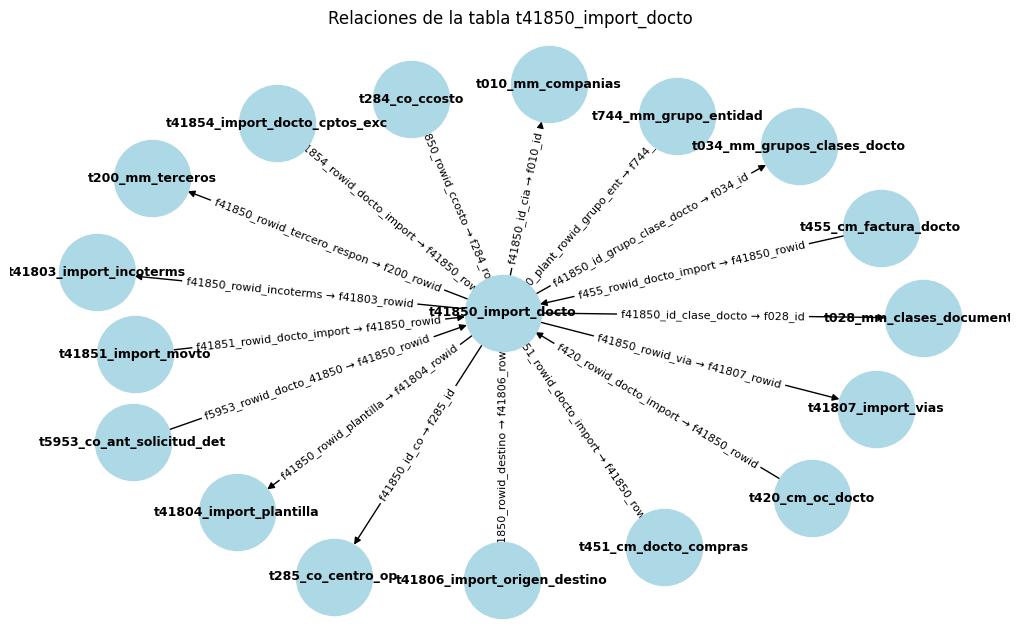

In [1]:
import pyodbc
import json
import networkx as nx
import matplotlib.pyplot as plt

# 🔑 Cargar credenciales
with open("config.json") as f:
    creds = json.load(f)

server = "10.75.71.10,1433"
database = "UnoEE"
username = creds["DB_USER"]
password = creds["DB_PASS"]

# 🔌 Conexión
conn = pyodbc.connect(
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password};"
    f"Encrypt=yes;"
    f"TrustServerCertificate=yes;"
)

cursor = conn.cursor()

# 🔎 Query para dependencias de la tabla
cursor.execute("""
SELECT 
    tp.name AS parent_table,
    ref.name AS referenced_table,
    cpa.name AS parent_column,
    cref.name AS referenced_column
FROM sys.foreign_keys fk
INNER JOIN sys.tables tp ON fk.parent_object_id = tp.object_id
INNER JOIN sys.tables ref ON fk.referenced_object_id = ref.object_id
INNER JOIN sys.foreign_key_columns fkc ON fkc.constraint_object_id = fk.object_id
INNER JOIN sys.columns cpa ON fkc.parent_column_id = cpa.column_id AND fkc.parent_object_id = cpa.object_id
INNER JOIN sys.columns cref ON fkc.referenced_column_id = cref.column_id AND fkc.referenced_object_id = cref.object_id
WHERE tp.name = 't41850_import_docto' OR ref.name = 't41850_import_docto'
""")

rows = cursor.fetchall()

# 📊 Crear grafo
G = nx.DiGraph()
for parent, ref, col_p, col_r in rows:
    G.add_edge(parent, ref, label=f"{col_p} → {col_r}")

# Dibujar
pos = nx.spring_layout(G, k=1.5)
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=9, font_weight="bold", arrows=True)
edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Relaciones de la tabla t41850_import_docto", fontsize=12)
plt.show()


In [19]:
import pyodbc
import json
import pandas as pd
from pyvis.network import Network

# 🔑 Cargar credenciales
with open("config.json") as f:
    creds = json.load(f)

server = "10.75.71.10,1433"
database = "UnoEE"
username = creds["DB_USER"]
password = creds["DB_PASS"]

# 🔌 Conexión a SQL Server
conn = pyodbc.connect(
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password};"
    f"Encrypt=yes;"
    f"TrustServerCertificate=yes;"
)
cursor = conn.cursor()

# 🔎 Función para traer dependencias de una tabla
def get_relaciones(tabla):
    cursor.execute(f"""
    SELECT 
        tp.name AS parent_table,
        ref.name AS referenced_table,
        cpa.name AS parent_column,
        cref.name AS referenced_column
    FROM sys.foreign_keys fk
    INNER JOIN sys.tables tp ON fk.parent_object_id = tp.object_id
    INNER JOIN sys.tables ref ON fk.referenced_object_id = ref.object_id
    INNER JOIN sys.foreign_key_columns fkc ON fkc.constraint_object_id = fk.object_id
    INNER JOIN sys.columns cpa ON fkc.parent_column_id = cpa.column_id AND fkc.parent_object_id = cpa.object_id
    INNER JOIN sys.columns cref ON fkc.referenced_column_id = cref.column_id AND fkc.referenced_object_id = cref.object_id
    WHERE tp.name = '{tabla}' OR ref.name = '{tabla}'
    """)
    return cursor.fetchall()

# 🔁 Loop interactivo para drill-down
tabla = "t41850_import_docto"  # tabla inicial
while True:
    rows = get_relaciones(tabla)

    if not rows:
        print(f"⚠️ No se encontraron relaciones para la tabla {tabla}")
    else:
        # 📑 Guardar en Excel (conversión a tuplas para evitar error)
        rows_data = [tuple(r) for r in rows]
        df = pd.DataFrame(rows_data, columns=["parent_table", "referenced_table", "parent_column", "referenced_column"])
        excel_file = f"relaciones_{tabla}.xlsx"
        df.to_excel(excel_file, index=False)
        print(f"✅ Relaciones exportadas a {excel_file}")

        # 🌐 Crear grafo interactivo con Pyvis
        net = Network(notebook=False, directed=True, height="600px", width="100%")
        for parent, ref, col_p, col_r in rows_data:
            net.add_node(parent, label=parent, color="lightblue")
            net.add_node(ref, label=ref, color="lightgreen")
            net.add_edge(parent, ref, title=f"{col_p} → {col_r}")

        html_file = f"grafo_relaciones_{tabla}.html"
        net.write_html(html_file)  # ✅ evita el error de NoneType
        print(f"✅ Visualización creada en {html_file}")

    # Preguntar si quiere drill-down en otra tabla
    next_tabla = input("\n👉 Ingresa otra tabla para seguir el drill-down (ENTER para salir): ")
    if not next_tabla.strip():
        print("🔚 Fin del análisis de dependencias.")
        break
    else:
        tabla = next_tabla.strip()


✅ Relaciones exportadas a relaciones_t41850_import_docto.xlsx
✅ Visualización creada en grafo_relaciones_t41850_import_docto.html
✅ Relaciones exportadas a relaciones_t420_cm_oc_docto.xlsx
✅ Visualización creada en grafo_relaciones_t420_cm_oc_docto.html
🔚 Fin del análisis de dependencias.


In [16]:
import pyodbc
import json
import pandas as pd
from pyvis.network import Network

# 🔑 Cargar credenciales
with open("config.json") as f:
    creds = json.load(f)

server = "10.75.71.10,1433"
database = "UnoEE"
username = creds["DB_USER"]
password = creds["DB_PASS"]

# 🔌 Conexión a SQL Server
conn = pyodbc.connect(
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password};"
    f"Encrypt=yes;"
    f"TrustServerCertificate=yes;"
)
cursor = conn.cursor()

# 🔎 Función para traer dependencias de una tabla
def get_relaciones(tabla):
    cursor.execute(f"""
    SELECT 
        tp.name AS parent_table,
        ref.name AS referenced_table,
        cpa.name AS parent_column,
        cref.name AS referenced_column
    FROM sys.foreign_keys fk
    INNER JOIN sys.tables tp ON fk.parent_object_id = tp.object_id
    INNER JOIN sys.tables ref ON fk.referenced_object_id = ref.object_id
    INNER JOIN sys.foreign_key_columns fkc ON fkc.constraint_object_id = fk.object_id
    INNER JOIN sys.columns cpa ON fkc.parent_column_id = cpa.column_id AND fkc.parent_object_id = cpa.object_id
    INNER JOIN sys.columns cref ON fkc.referenced_column_id = cref.column_id AND fkc.referenced_object_id = cref.object_id
    WHERE tp.name = '{tabla}' OR ref.name = '{tabla}'
    """)
    return cursor.fetchall()

# 🔁 Loop interactivo
tabla = "t41850_import_docto"
while True:
    rows = get_relaciones(tabla)

    if not rows:
        print(f"⚠️ No se encontraron relaciones para {tabla}")
    else:
        rows_data = [tuple(r) for r in rows]
        df = pd.DataFrame(rows_data, columns=["parent_table", "referenced_table", "parent_column", "referenced_column"])
        excel_file = f"relaciones_{tabla}.xlsx"
        df.to_excel(excel_file, index=False)
        print(f"✅ Relaciones exportadas a {excel_file}")

        # 🌐 Crear grafo
        net = Network(notebook=False, directed=True, height="700px", width="100%")

        nodos = set()
        for parent, ref, col_p, col_r in rows_data:
            net.add_node(parent, label=parent, color="lightblue")
            net.add_node(ref, label=ref, color="lightgreen")
            net.add_edge(parent, ref, title=f"{col_p} → {col_r}")
            nodos.add(parent)
            nodos.add(ref)

        html_file = f"grafo_relaciones_{tabla}.html"
        net.write_html(html_file)

        # 📌 Inyectar panel de filtros al HTML
        with open(html_file, "r", encoding="utf-8") as f:
            contenido = f.read()

        # Panel dinámico de checkboxes
        panel_html = """
        <div id="filtro" style="position:fixed; top:10px; right:10px; 
             background:white; border:1px solid gray; padding:10px; max-height:500px; 
             overflow-y:scroll; z-index:999;">
        <b>Filtrar Tablas</b><br>
        """

        for nodo in sorted(nodos):
            panel_html += f'<label><input type="checkbox" checked onclick="toggleNode(\'{nodo}\')"> {nodo}</label><br>'

        panel_html += """
        </div>
        <script>
        function toggleNode(name) {
            var nodeId = null;
            // Buscar nodo por label
            for (let n of nodes.get()) {
                if (n.label === name) {
                    nodeId = n.id;
                    break;
                }
            }
            if (nodeId !== null) {
                var node = nodes.get(nodeId);
                if (node.hidden) {
                    nodes.update({id: nodeId, hidden:false});
                } else {
                    nodes.update({id: nodeId, hidden:true});
                }
            }
        }
        </script>
        """

        # Insertar panel antes de </body>
        contenido = contenido.replace("</body>", panel_html + "</body>")

        with open(html_file, "w", encoding="utf-8") as f:
            f.write(contenido)

        print(f"✅ Grafo con filtro generado en {html_file}")

    # Preguntar siguiente tabla
    next_tabla = input("\n👉 Ingresa otra tabla para drill-down (ENTER para salir): ")
    if not next_tabla.strip():
        print("🔚 Fin del análisis de dependencias.")
        break
    else:
        tabla = next_tabla.strip()


✅ Relaciones exportadas a relaciones_t41850_import_docto.xlsx
✅ Grafo con filtro generado en grafo_relaciones_t41850_import_docto.html
🔚 Fin del análisis de dependencias.


In [ ]:
####3

import pyodbc
import json
import pandas as pd
from pyvis.network import Network
import os
import webbrowser

# 🔑 Cargar credenciales
with open("config.json") as f:
    creds = json.load(f)

server = "10.75.71.10,1433"
database = "UnoEE"
username = creds["DB_USER"]
password = creds["DB_PASS"]

# 🔌 Conexión a SQL Server
conn = pyodbc.connect(
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password};"
    f"Encrypt=yes;"
    f"TrustServerCertificate=yes;"
)
cursor = conn.cursor()

# 🔎 Función para traer dependencias de una tabla
def get_relaciones(tabla):
    cursor.execute(f"""
    SELECT 
        tp.name AS parent_table,
        ref.name AS referenced_table,
        cpa.name AS parent_column,
        cref.name AS referenced_column
    FROM sys.foreign_keys fk
    INNER JOIN sys.tables tp ON fk.parent_object_id = tp.object_id
    INNER JOIN sys.tables ref ON fk.referenced_object_id = ref.object_id
    INNER JOIN sys.foreign_key_columns fkc ON fkc.constraint_object_id = fk.object_id
    INNER JOIN sys.columns cpa ON fkc.parent_column_id = cpa.column_id AND fkc.parent_object_id = cpa.object_id
    INNER JOIN sys.columns cref ON fkc.referenced_column_id = cref.column_id AND fkc.referenced_object_id = cref.object_id
    WHERE tp.name = '{tabla}' OR ref.name = '{tabla}'
    """)
    return cursor.fetchall()

# 🔁 Loop interactivo
tabla = "t41850_import_docto"
df_global = pd.DataFrame(columns=["parent_table", "referenced_table", "parent_column", "referenced_column"])

while True:
    rows = get_relaciones(tabla)

    if not rows:
        print(f"⚠️ No se encontraron relaciones para {tabla}")
    else:
        rows_data = [tuple(r) for r in rows]
        df_temp = pd.DataFrame(rows_data, columns=["parent_table", "referenced_table", "parent_column", "referenced_column"])
        df_global = pd.concat([df_global, df_temp], ignore_index=True)

        # 🌐 Crear grafo
        net = Network(notebook=False, directed=True, height="750px", width="100%")

        # Sin heading duplicado de PyVis
        net.set_options("""var options = {
          "nodes": {
            "font": {"size":14,"face":"Arial"}
          },
          "edges": {
            "color": {"inherit":true},
            "smooth": false
          },
          "physics": {"stabilization":true}
        }""")

        nodos = set()
        for parent, ref, col_p, col_r in rows_data:
            if parent == tabla:
                net.add_node(parent, label=parent, color="crimson", shape="box", font={"size":18,"color":"white"})
            else:
                net.add_node(parent, label=parent, color="cornflowerblue", font={"size":14})
            if ref == tabla:
                net.add_node(ref, label=ref, color="crimson", shape="box", font={"size":18,"color":"white"})
            else:
                net.add_node(ref, label=ref, color="mediumseagreen", font={"size":14})
            net.add_edge(parent, ref, title=f"{col_p} → {col_r}")
            nodos.add(parent)
            nodos.add(ref)

        # ⚡ Generar HTML en UTF-8
        html_file = f"grafo_relaciones_{tabla}.html"
        html_content = net.generate_html()

        # 📌 Inyectar estilos y paneles UX
        panel_html = f"""
        <style>
            body {{ font-family: Arial, sans-serif; background:#fafafa; margin:0; }}
            h1.title {{
                text-align:center; font-size:22px; font-weight:bold; margin:15px 0;
                color:#222;
            }}
            .panel {{
                position:fixed; right:20px; background:white; border-radius:10px;
                border:1px solid #ddd; padding:12px; box-shadow:0 4px 8px rgba(0,0,0,0.1);
                font-size:14px; line-height:1.4; width:220px;
            }}
            .panel h3 {{
                margin-top:0; font-size:15px; color:#444;
            }}
            .btn {{
                background:#f5f5f5; border:1px solid #ccc; border-radius:6px; padding:4px 8px;
                margin:2px; cursor:pointer; font-size:13px;
            }}
            .btn:hover {{ background:#e0e0e0; }}
            #filtro {{ top:70px; max-height:320px; overflow-y:auto; }}
            #filtro_tipo {{ top:410px; }}
            #buscarTabla {{
                width:100%; padding:6px; margin:6px 0; border:1px solid #ccc; border-radius:6px;
            }}
        </style>

        <h1 class="title">Relaciones de la tabla: {tabla}</h1>

        <div id="filtro" class="panel">
          <h3>Filtrar Tablas</h3>
          <input type="text" id="buscarTabla" placeholder="Buscar tabla...">
          <div>
            <button class="btn" onclick="seleccionarTodos(true)">Seleccionar Todo</button>
            <button class="btn" onclick="seleccionarTodos(false)">Quitar Todo</button>
          </div>
          <div id="listaTablas"></div>
        </div>

        <div id="filtro_tipo" class="panel">
          <h3>Filtrar por Tipo</h3>
          <label><input type="checkbox" checked onclick="toggleTipo('parent', this)"> Parent Tables</label><br>
          <label><input type="checkbox" checked onclick="toggleTipo('referenced', this)"> Referenced Tables</label>
        </div>

        <script>
        const originalTable = "{tabla}";
        var tablasSet = new Set();
        nodes.get().forEach(n => tablasSet.add(n.label));

        function renderLista() {{
            var lista = document.getElementById("listaTablas");
            lista.innerHTML = "";
            var filtro = document.getElementById("buscarTabla").value.toLowerCase();
            Array.from(tablasSet).sort().forEach(tabla => {{
                if (tabla.toLowerCase().includes(filtro)) {{
                    if (tabla === originalTable) {{
                        lista.innerHTML += '<label style="color:crimson;font-weight:bold;"><input type="checkbox" checked disabled> ' + tabla + ' (Original)</label><br>';
                    }} else {{
                        lista.innerHTML += '<label><input type="checkbox" class="chkTabla" value="'+tabla+'" checked onclick="toggleNode(\\''+tabla+'\\')"> ' + tabla + '</label><br>';
                    }}
                }}
            }});
        }}
        renderLista();
        document.getElementById("buscarTabla").addEventListener("keyup", renderLista);

        function toggleNode(name, forceValue=null) {{
            if (name === originalTable) return;
            var nodeId = null;
            for (let n of nodes.get()) {{
                if (n.label === name) {{ nodeId = n.id; break; }}
            }}
            if (nodeId !== null) {{
                var node = nodes.get(nodeId);
                var hide = forceValue !== null ? !forceValue : !node.hidden;
                nodes.update({{id: nodeId, hidden: hide}});
                edges.get().forEach(function(e) {{
                    if (e.from === nodeId || e.to === nodeId) {{
                        edges.update({{id: e.id, hidden: hide}});
                    }}
                }});
            }}
        }}
        function seleccionarTodos(valor) {{
            document.querySelectorAll(".chkTabla").forEach(chk => {{
                chk.checked = valor;
                toggleNode(chk.value, valor);
            }});
        }}
        function toggleTipo(tipo, elem) {{
            edges.get().forEach(function(e) {{
                var src = nodes.get(e.from).label;
                var dst = nodes.get(e.to).label;
                if (tipo === "parent" && src) {{
                    if (src !== originalTable) {{
                        edges.update({{id: e.id, hidden: !elem.checked}});
                        nodes.update({{id: e.from, hidden: !elem.checked}});
                    }}
                }}
                if (tipo === "referenced" && dst) {{
                    if (dst !== originalTable) {{
                        edges.update({{id: e.id, hidden: !elem.checked}});
                        nodes.update({{id: e.to, hidden: !elem.checked}});
                    }}
                }}
            }});
        }}
        </script>
        """

        html_content = html_content.replace("</body>", panel_html + "</body>")
        with open(html_file, "w", encoding="utf-8") as f:
            f.write(html_content)

        print(f"✅ Grafo UX final generado en {html_file}")
        webbrowser.open(f"file://{os.path.abspath(html_file)}", new=2)

    next_tabla = input("\n👉 Ingresa otra tabla para drill-down (ENTER para salir): ")
    if not next_tabla.strip():
        print("🔚 Fin del análisis de dependencias.")
        excel_file = "relaciones_drilldown.xlsx"
        df_global.to_excel(excel_file, index=False)
        print(f"✅ Archivo único generado: {excel_file}")
        break
    else:
        tabla = next_tabla.strip()


✅ Grafo UX final generado en grafo_relaciones_t41850_import_docto.html
🔚 Fin del análisis de dependencias.
✅ Archivo único generado: relaciones_drilldown.xlsx


In [20]:
import pyodbc
import json
import pandas as pd
from pyvis.network import Network
import os
import webbrowser

# 🔑 Cargar credenciales
with open("config.json") as f:
    creds = json.load(f)

server = "10.75.71.10,1433"
database = "UnoEE"
username = creds["DB_USER"]
password = creds["DB_PASS"]

# 🔌 Conexión a SQL Server
conn = pyodbc.connect(
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password};"
    f"Encrypt=yes;"
    f"TrustServerCertificate=yes;"
)
cursor = conn.cursor()

# 🔎 Función para traer dependencias de una tabla
def get_relaciones(tabla):
    cursor.execute(f"""
    SELECT 
        tp.name AS parent_table,
        ref.name AS referenced_table,
        cpa.name AS parent_column,
        cref.name AS referenced_column
    FROM sys.foreign_keys fk
    INNER JOIN sys.tables tp ON fk.parent_object_id = tp.object_id
    INNER JOIN sys.tables ref ON fk.referenced_object_id = ref.object_id
    INNER JOIN sys.foreign_key_columns fkc ON fkc.constraint_object_id = fk.object_id
    INNER JOIN sys.columns cpa ON fkc.parent_column_id = cpa.column_id AND fkc.parent_object_id = cpa.object_id
    INNER JOIN sys.columns cref ON fkc.referenced_column_id = cref.column_id AND fkc.referenced_object_id = cref.object_id
    WHERE tp.name = '{tabla}' OR ref.name = '{tabla}'
    """)
    return cursor.fetchall()

# 🔁 Loop interactivo
tabla = "t41850_import_docto"
df_global = pd.DataFrame(columns=["parent_table", "referenced_table", "parent_column", "referenced_column"])

while True:
    rows = get_relaciones(tabla)

    if not rows:
        print(f"⚠️ No se encontraron relaciones para {tabla}")
    else:
        rows_data = [tuple(r) for r in rows]
        df_temp = pd.DataFrame(rows_data, columns=["parent_table", "referenced_table", "parent_column", "referenced_column"])
        df_global = pd.concat([df_global, df_temp], ignore_index=True)

        # 🌐 Crear grafo crudo (sin embellecer)
        net = Network(notebook=False, directed=True, height="750px", width="100%")

        nodos = set()
        for parent, ref, col_p, col_r in rows_data:
            # Nodos
            if parent == tabla:
                net.add_node(parent, label=parent, color="crimson", shape="box", font={"size":18,"color":"white"})
            else:
                net.add_node(parent, label=parent, color="lightblue")
            if ref == tabla:
                net.add_node(ref, label=ref, color="crimson", shape="box", font={"size":18,"color":"white"})
            else:
                net.add_node(ref, label=ref, color="lightgreen")

            # ⚡ Una arista por cada FK (varias flechas si hay varias columnas)
            net.add_edge(parent, ref, title=f"{col_p} → {col_r}")

            nodos.add(parent)
            nodos.add(ref)

        # ⚡ Generar HTML en UTF-8
        html_file = f"grafo_relaciones_{tabla}.html"
        html_content = net.generate_html()

        # 📌 Inyectar estilos, título overlay y paneles UX
        panel_html = f"""
        <style>
            html, body {{ margin: 0; padding: 0; height: 100%; overflow: hidden; }}
            #mynetwork {{ height: 100% !important; }}
            #titulo {{
                position: absolute; top: 10px; left: 50%; transform: translateX(-50%);
                font-size: 22px; font-weight: bold; color: #222;
                background: rgba(255,255,255,0.9); padding: 6px 12px;
                border-radius: 8px; box-shadow: 0 2px 6px rgba(0,0,0,0.15);
                z-index: 1000;
            }}
            .panel {{
                position:fixed; right:20px; background:white; border-radius:10px;
                border:1px solid #ddd; padding:12px; box-shadow:0 4px 8px rgba(0,0,0,0.1);
                font-size:14px; line-height:1.4; width:240px;
            }}
            .panel h3 {{
                margin-top:0; font-size:15px; color:#444;
            }}
            .btn {{
                background:#f5f5f5; border:1px solid #ccc; border-radius:6px; padding:4px 8px;
                margin:2px; cursor:pointer; font-size:13px;
            }}
            .btn:hover {{ background:#e0e0e0; }}
            #filtro {{ top:70px; max-height:320px; overflow-y:auto; }}
            #filtro_tipo {{ top:420px; }}
            #buscarTabla {{
                width:100%; padding:6px; margin:6px 0; border:1px solid #ccc; border-radius:6px;
            }}
        </style>

        <div id="titulo">Tabla: "{tabla}" → Relaciones con otras tablas</div>

        <div id="filtro" class="panel">
          <h3>Filtrar Tablas</h3>
          <input type="text" id="buscarTabla" placeholder="Buscar tabla...">
          <div>
            <button class="btn" onclick="seleccionarTodos(true)">Seleccionar Todo</button>
            <button class="btn" onclick="seleccionarTodos(false)">Quitar Todo</button>
          </div>
          <div id="listaTablas"></div>
        </div>

        <div id="filtro_tipo" class="panel">
          <h3>Filtrar por Tipo</h3>
          <label><input type="checkbox" checked onclick="toggleTipo('parent', this)"> Parent Tables</label><br>
          <label><input type="checkbox" checked onclick="toggleTipo('referenced', this)"> Referenced Tables</label>
        </div>

        <script>
        const originalTable = "{tabla}";
        var tablasSet = new Set();
        nodes.get().forEach(n => tablasSet.add(n.label));

        function renderLista() {{
            var lista = document.getElementById("listaTablas");
            lista.innerHTML = "";
            var filtro = document.getElementById("buscarTabla").value.toLowerCase();
            Array.from(tablasSet).sort().forEach(tabla => {{
                if (tabla.toLowerCase().includes(filtro)) {{
                    if (tabla === originalTable) {{
                        lista.innerHTML += '<label style="color:crimson;font-weight:bold;"><input type="checkbox" checked disabled> ' + tabla + ' (Original)</label><br>';
                    }} else {{
                        lista.innerHTML += '<label><input type="checkbox" class="chkTabla" value="'+tabla+'" checked onclick="toggleNode(\\''+tabla+'\\')"> ' + tabla + '</label><br>';
                    }}
                }}
            }});
        }}
        renderLista();
        document.getElementById("buscarTabla").addEventListener("keyup", renderLista);

        function toggleNode(name, forceValue=null) {{
            if (name === originalTable) return;
            var nodeId = null;
            for (let n of nodes.get()) {{
                if (n.label === name) {{ nodeId = n.id; break; }}
            }}
            if (nodeId !== null) {{
                var node = nodes.get(nodeId);
                var hide = forceValue !== null ? !forceValue : !node.hidden;
                nodes.update({{id: nodeId, hidden: hide}});
                edges.get().forEach(function(e) {{
                    if (e.from === nodeId || e.to === nodeId) {{
                        edges.update({{id: e.id, hidden: hide}});
                    }}
                }});
            }}
        }}

        function seleccionarTodos(valor) {{
            document.querySelectorAll(".chkTabla").forEach(chk => {{
                chk.checked = valor;
                toggleNode(chk.value, valor);
            }});
        }}

        // 🔥 Sincroniza Parent/Referenced con checkboxes
        function toggleTipo(tipo, elem) {{
            edges.get().forEach(function(e) {{
                var src = nodes.get(e.from).label;
                var dst = nodes.get(e.to).label;

                if (tipo === "parent" && src) {{
                    if (src !== originalTable) {{
                        edges.update({{id: e.id, hidden: !elem.checked}});
                        nodes.update({{id: e.from, hidden: !elem.checked}});
                        document.querySelectorAll(".chkTabla").forEach(chk => {{
                            if (chk.value === src) chk.checked = elem.checked;
                        }});
                    }}
                }}
                if (tipo === "referenced" && dst) {{
                    if (dst !== originalTable) {{
                        edges.update({{id: e.id, hidden: !elem.checked}});
                        nodes.update({{id: e.to, hidden: !elem.checked}});
                        document.querySelectorAll(".chkTabla").forEach(chk => {{
                            if (chk.value === dst) chk.checked = elem.checked;
                        }});
                    }}
                }}
            }});
        }}
        </script>
        """

        html_content = html_content.replace("</body>", panel_html + "</body>")
        with open(html_file, "w", encoding="utf-8") as f:
            f.write(html_content)

        print(f"✅ Grafo UX final generado en {html_file}")
        webbrowser.open(f"file://{os.path.abspath(html_file)}", new=2)

    next_tabla = input("\n👉 Ingresa otra tabla para drill-down (ENTER para salir): ")
    if not next_tabla.strip():
        print("🔚 Fin del análisis de dependencias.")
        excel_file = "relaciones_drilldown.xlsx"
        df_global.to_excel(excel_file, index=False)
        print(f"✅ Archivo único generado: {excel_file}")
        break
    else:
        tabla = next_tabla.strip()


✅ Grafo UX final generado en grafo_relaciones_t41850_import_docto.html
🔚 Fin del análisis de dependencias.
✅ Archivo único generado: relaciones_drilldown.xlsx


In [1]:
#Ultimo_pdte tiembla

import pyodbc
import json
import pandas as pd
from pyvis.network import Network
import os
import webbrowser

# 🔑 Cargar credenciales
with open("config.json") as f:
    creds = json.load(f)

server = "10.75.71.10,1433"
database = "UnoEE"
username = creds["DB_USER"]
password = creds["DB_PASS"]

# 🔌 Conexión a SQL Server
conn = pyodbc.connect(
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"UID={username};"
    f"PWD={password};"
    f"Encrypt=yes;"
    f"TrustServerCertificate=yes;"
)
cursor = conn.cursor()

# 🔎 Función para traer dependencias de una tabla
def get_relaciones(tabla):
    cursor.execute(f"""
    SELECT 
        tp.name AS parent_table,
        ref.name AS referenced_table,
        cpa.name AS parent_column,
        cref.name AS referenced_column
    FROM sys.foreign_keys fk
    INNER JOIN sys.tables tp ON fk.parent_object_id = tp.object_id
    INNER JOIN sys.tables ref ON fk.referenced_object_id = ref.object_id
    INNER JOIN sys.foreign_key_columns fkc ON fkc.constraint_object_id = fk.object_id
    INNER JOIN sys.columns cpa ON fkc.parent_column_id = cpa.column_id AND fkc.parent_object_id = cpa.object_id
    INNER JOIN sys.columns cref ON fkc.referenced_column_id = cref.column_id AND fkc.referenced_object_id = cref.object_id
    WHERE tp.name = '{tabla}' OR ref.name = '{tabla}'
    """)
    return cursor.fetchall()

# 🔁 Preguntar tabla inicial
tabla = input("👉 Ingresa el nombre de la tabla inicial: ").strip()
if not tabla:
    print("⚠️ Debes ingresar una tabla para iniciar el análisis.")
    exit()

df_global = pd.DataFrame(columns=["parent_table", "referenced_table", "parent_column", "referenced_column"])

while True:
    rows = get_relaciones(tabla)

    if not rows:
        print(f"⚠️ No se encontraron relaciones para {tabla}")
    else:
        rows_data = [tuple(r) for r in rows]
        df_temp = pd.DataFrame(rows_data, columns=["parent_table", "referenced_table", "parent_column", "referenced_column"])
        df_global = pd.concat([df_global, df_temp], ignore_index=True)

        # 🌐 Crear grafo crudo
        net = Network(notebook=False, directed=True, height="750px", width="100%")

        nodos = set()
        for parent, ref, col_p, col_r in rows_data:
            # Nodos
            if parent == tabla:
                net.add_node(parent, label=parent, color="crimson", shape="box", font={"size":18,"color":"white"})
            else:
                net.add_node(parent, label=parent, color="lightblue")
            if ref == tabla:
                net.add_node(ref, label=ref, color="crimson", shape="box", font={"size":18,"color":"white"})
            else:
                net.add_node(ref, label=ref, color="lightgreen")

            # ⚡ Una arista por cada FK
            net.add_edge(parent, ref, title=f"{col_p} → {col_r}")

            nodos.add(parent)
            nodos.add(ref)

        # ⚡ Generar HTML en UTF-8
        html_file = f"grafo_relaciones_{tabla}.html"
        html_content = net.generate_html()

        # 📌 Inyectar estilos y paneles UX
        panel_html = f"""
        <style>
            html, body {{ margin: 0; padding: 0; height: 100%; overflow: hidden; }}
            #mynetwork {{ height: 100% !important; }}
            #titulo {{
                position: absolute; top: 10px; left: 50%; transform: translateX(-50%);
                font-size: 22px; font-weight: bold; color: #222;
                background: rgba(255,255,255,0.9); padding: 6px 12px;
                border-radius: 8px; box-shadow: 0 2px 6px rgba(0,0,0,0.15);
                z-index: 1000;
            }}
            .panel {{
                position:fixed; right:20px; background:white; border-radius:10px;
                border:1px solid #ddd; padding:12px; box-shadow:0 4px 8px rgba(0,0,0,0.1);
                font-size:14px; line-height:1.4; width:240px;
            }}
            .panel h3 {{
                margin-top:0; font-size:15px; color:#444;
            }}
            .btn {{
                background:#f5f5f5; border:1px solid #ccc; border-radius:6px; padding:4px 8px;
                margin:2px; cursor:pointer; font-size:13px;
            }}
            .btn:hover {{ background:#e0e0e0; }}
            #filtro {{ top:70px; max-height:320px; overflow-y:auto; }}
            #filtro_tipo {{ top:420px; }}
            #buscarTabla {{
                width:100%; padding:6px; margin:6px 0; border:1px solid #ccc; border-radius:6px;
            }}
        </style>

        <div id="titulo">Tabla: "{tabla}" → Relaciones con otras tablas</div>

        <div id="filtro" class="panel">
          <h3>Filtrar Tablas</h3>
          <input type="text" id="buscarTabla" placeholder="Buscar tabla...">
          <div>
            <button class="btn" onclick="seleccionarTodos(true)">Seleccionar Todo</button>
            <button class="btn" onclick="seleccionarTodos(false)">Quitar Todo</button>
          </div>
          <div id="listaTablas"></div>
        </div>

        <div id="filtro_tipo" class="panel">
          <h3>Filtrar por Tipo</h3>
          <label><input type="checkbox" checked onclick="toggleTipo('parent', this)"> Parent Tables</label><br>
          <label><input type="checkbox" checked onclick="toggleTipo('referenced', this)"> Referenced Tables</label>
        </div>

        <script>
        const originalTable = "{tabla}";
        var tablasSet = new Set();
        nodes.get().forEach(n => tablasSet.add(n.label));

        function renderLista() {{
            var lista = document.getElementById("listaTablas");
            lista.innerHTML = "";
            var filtro = document.getElementById("buscarTabla").value.toLowerCase();
            Array.from(tablasSet).sort().forEach(tabla => {{
                if (tabla.toLowerCase().includes(filtro)) {{
                    if (tabla === originalTable) {{
                        lista.innerHTML += '<label style="color:crimson;font-weight:bold;"><input type="checkbox" checked disabled> ' + tabla + ' (Original)</label><br>';
                    }} else {{
                        lista.innerHTML += '<label><input type="checkbox" class="chkTabla" value="'+tabla+'" checked onclick="toggleNode(\\''+tabla+'\\')"> ' + tabla + '</label><br>';
                    }}
                }}
            }});
        }}
        renderLista();
        document.getElementById("buscarTabla").addEventListener("keyup", renderLista);

        function toggleNode(name, forceValue=null) {{
            if (name === originalTable) return;
            var nodeId = null;
            for (let n of nodes.get()) {{
                if (n.label === name) {{ nodeId = n.id; break; }}
            }}
            if (nodeId !== null) {{
                var node = nodes.get(nodeId);
                var hide = forceValue !== null ? !forceValue : !node.hidden;
                nodes.update({{id: nodeId, hidden: hide}});
                edges.get().forEach(function(e) {{
                    if (e.from === nodeId || e.to === nodeId) {{
                        edges.update({{id: e.id, hidden: hide}});
                    }}
                }});
            }}
        }}

        function seleccionarTodos(valor) {{
            document.querySelectorAll(".chkTabla").forEach(chk => {{
                chk.checked = valor;
                toggleNode(chk.value, valor);
            }});
        }}

        // 🔥 Sincroniza Parent/Referenced con checkboxes
        function toggleTipo(tipo, elem) {{
            edges.get().forEach(function(e) {{
                var src = nodes.get(e.from).label;
                var dst = nodes.get(e.to).label;

                if (tipo === "parent" && src) {{
                    if (src !== originalTable) {{
                        edges.update({{id: e.id, hidden: !elem.checked}});
                        nodes.update({{id: e.from, hidden: !elem.checked}});
                        document.querySelectorAll(".chkTabla").forEach(chk => {{
                            if (chk.value === src) chk.checked = elem.checked;
                        }});
                    }}
                }}
                if (tipo === "referenced" && dst) {{
                    if (dst !== originalTable) {{
                        edges.update({{id: e.id, hidden: !elem.checked}});
                        nodes.update({{id: e.to, hidden: !elem.checked}});
                        document.querySelectorAll(".chkTabla").forEach(chk => {{
                            if (chk.value === dst) chk.checked = elem.checked;
                        }});
                    }}
                }}
            }});
        }}
        </script>
        """

        html_content = html_content.replace("</body>", panel_html + "</body>")
        with open(html_file, "w", encoding="utf-8") as f:
            f.write(html_content)

        print(f"✅ Grafo UX final generado en {html_file}")
        webbrowser.open(f"file://{os.path.abspath(html_file)}", new=2)

    next_tabla = input("\n👉 Ingresa otra tabla para drill-down (ENTER para salir): ")
    if not next_tabla.strip():
        print("🔚 Fin del análisis de dependencias.")
        excel_file = "relaciones_drilldown.xlsx"
        df_global.to_excel(excel_file, index=False)
        print(f"✅ Archivo único generado: {excel_file}")
        break
    else:
        tabla = next_tabla.strip()



✅ Grafo UX final generado en grafo_relaciones_t41850_import_docto.html
🔚 Fin del análisis de dependencias.
✅ Archivo único generado: relaciones_drilldown.xlsx
